In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

/home/bharaj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import regularizers

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [5]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [6]:
### READ DATA ###

df = pd.read_csv('whole_mal.tsv',sep='\t',names=['category','text'])

print(df.shape)
df.head()

(6739, 2)


,category,text
0,unknown state,Ichayan fans pinne mmade ettan fansm ivde oru...
1,not-malayalam,Tovi 🥰 Best Wishes From #Kunjikka Fans
2,unknown state,Urutty koll .nallavanaaya unniyaya saiju kuru...
3,not-malayalam,Pls support me pls My channel subscribe...
4,Positive,Kalki super hit akum enn Bonny parayan paranju


In [7]:
### LABEL DISTRIBUTION ###

df.category.value_counts().plot.pie(figsize=(6,6))

In [8]:
### SIMPLE CLEAN OF TEXT ###

df['text'] = df.text.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')
df['text'] = df['text'].apply(lambda x: x.split())

In [9]:

#y = df['category'].tolist()
#y=np.array(y)
#type(y)

In [10]:
### SPLIT INTO TRAIN/TEST ###
y=df['category']
#y = pd.get_dummies(df['category']).values

X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=5, test_size=0.2)

In [11]:
print(type(y_train))
y_train.head()

<class 'pandas.core.series.Series'>


4616         Positive 
5193         Positive 
4502    not-malayalam 
4186         Positive 
4037    unknown state 
Name: category, dtype: object

In [12]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [13]:
y_train=pd.get_dummies(y_train).values

In [14]:
y_test=pd.get_dummies(y_test).values
y_test

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [15]:
print(X_train[0],y[0])

['ente', 'ponnnuuuuuuu', 'lalettaaa', 'baaki', 'oke', 'kili', 'vannit', 'parayam'] unknown state 


In [16]:
### MAP LABEL ###

diz_label = {}
for i,label in enumerate(df.category.factorize()[1]):
    diz_label[i] = label
    
diz_label

{0: 'unknown state ',
 1: 'not-malayalam ',
 2: 'Positive ',
 3: 'Negative ',
 4: 'Mixed feelings '}

In [17]:
### TRAIN WORD2VEC AND FASTTEXT ###

w2v = Word2Vec(size=100, window=5, min_count=4, seed=33)
w2v.build_vocab(X_train)
w2v.train(X_train, total_examples=w2v.corpus_count, epochs=10)

ft = FastText(size=100, window=5, min_count=4, seed=33)
ft.build_vocab(X_train)
ft.train(X_train, total_examples=ft.corpus_count, epochs=10)

In [18]:
### TRANSFORM ORIGINAL TEXT INTO SEQUENCES AND COMPUTE PADDING ###

max_len = 200

tokenizer = Tokenizer(lower=True, split='')
tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_train = pad_sequences(sequence_train, maxlen=max_len)

sequence_test = tokenizer.texts_to_sequences(X_test)
sequence_test = pad_sequences(sequence_test, maxlen=max_len)

sequence_train = np.asarray(sequence_train)
sequence_test = np.asarray(sequence_test)

print(sequence_train.shape, sequence_test.shape)

(5391, 200) (1348, 200)


In [19]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM WORD2VEC ###

embedding_matrix_w2v = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_w2v[i] = w2v.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 12177


In [20]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM FASTTEXT ###

embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 0


In [21]:
### DEFINE INPUT LAYER FOR EMBEDDINGS READING AND CONCATENATION ###

def Concat_Emb(list_emb, maxlen):
    
    inputs = []
    output = []
    for embedding in list_emb:
        
        inp = Input(shape=(maxlen,))
        emb = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding], trainable=False)(inp)
        emb = Reshape((-1,100,1))(emb)
        inputs.append(inp)
        output.append(emb)
        
    concat = Concatenate(axis=-1)(output)
    
    return Model(inputs, concat)

In [22]:
### TRY Concat_Emb ###

read_emb = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
read_emb.summary()

W0113 16:08:18.235057 140640957007616 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0113 16:08:18.267126 140640957007616 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0113 16:08:18.273404 140640957007616 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0113 16:08:18.288657 140640957007616 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_se

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     1371200     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     1371200     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 

In [23]:
### DEFINE DME AND CDME BLOCKS ###

def DME(maxlen):

    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    x = LSTM(2, return_sequences=True)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

def CDME(maxlen, latent_dim=2):
    
    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    x = Bidirectional(LSTM(latent_dim, return_sequences=True))(x)
    x = Lambda(lambda t: [t[:,:,:int(latent_dim/2+1)], t[:,:,int(latent_dim/2+1):]])(x)
    x = Maximum()(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

In [59]:
#class_weights = dict(enumerate(class_weights))

In [61]:
### DEFINE NETWORK WITH DME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
dme = DME(max_len)
x = dme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y_train.shape[1], activation='softmax',kernel_regularizer=regularizers.l1(0.01))(x)

dme_model = Model(concat_inp.input, out)
dme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dme_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 200, 100)     1371200     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 200, 100)     1371200     input_12[0][0]                   
__________________________________________________________________________________________________
reshape_13

In [62]:
dme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1,class_weight=class_weights)

W0109 15:55:35.121187 140043623216896 deprecation.py:323] From /home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4851 samples, validate on 540 samples
Epoch 1/20
 - 46s - loss: 1.8851 - acc: 0.2393 - val_loss: 1.8131 - val_acc: 0.2926
Epoch 2/20
 - 42s - loss: 1.7966 - acc: 0.2622 - val_loss: 1.7408 - val_acc: 0.3037
Epoch 3/20
 - 41s - loss: 1.7275 - acc: 0.2785 - val_loss: 1.6682 - val_acc: 0.2870
Epoch 4/20
 - 41s - loss: 1.6738 - acc: 0.2894 - val_loss: 1.6213 - val_acc: 0.3259
Epoch 5/20
 - 40s - loss: 1.6080 - acc: 0.3393 - val_loss: 1.5472 - val_acc: 0.3907
Epoch 6/20
 - 42s - loss: 1.5677 - acc: 0.3358 - val_loss: 1.5122 - val_acc: 0.3944
Epoch 7/20
 - 40s - loss: 1.5452 - acc: 0.3438 - val_loss: 1.4930 - val_acc: 0.3463
Epoch 8/20
 - 42s - loss: 1.4933 - acc: 0.3533 - val_loss: 1.4318 - val_acc: 0.4037
Epoch 9/20
 - 40s - loss: 1.4820 - acc: 0.3568 - val_loss: 1.4051 - val_acc: 0.4296
Epoch 10/20
 - 42s - loss: 1.4491 - acc: 0.3709 - val_loss: 1.4329 - val_acc: 0.3611
Epoch 11/20
 - 43s - loss: 1.4383 - acc: 0.3797 - val_loss: 1.4233 - val_acc: 0.4093
Epoch 12/20
 - 41s - loss: 

In [63]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)]))

                 precision    recall  f1-score   support

Mixed feelings        0.74      0.27      0.39       398
      Negative        0.28      0.83      0.42       177
      Positive        0.62      0.44      0.51       565
 not-malayalam        0.40      0.17      0.23       138
 unknown state        0.07      0.23      0.11        70

      micro avg       0.40      0.40      0.40      1348
      macro avg       0.42      0.39      0.33      1348
   weighted avg       0.56      0.40      0.42      1348



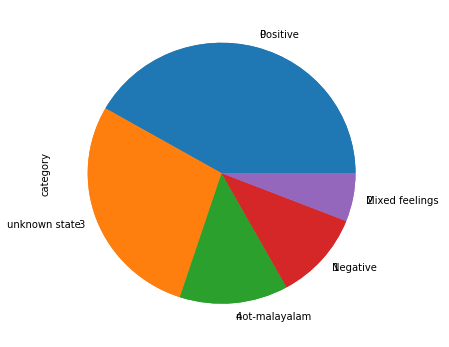

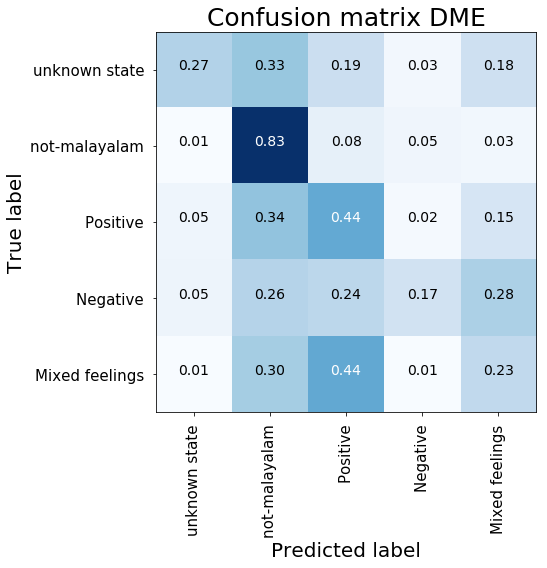

In [64]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix DME")
plt.show()

In [66]:
### DEFINE NETWORK WITH CDME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
cdme = CDME(max_len)
x = cdme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y_train.shape[1], activation='softmax',kernel_regularizer=regularizers.l1(0.01))(x)

cdme_model = Model(concat_inp.input, out)
cdme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cdme_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 200, 100)     1371200     input_17[0][0]                   
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 200, 100)     1371200     input_18[0][0]                   
__________________________________________________________________________________________________
reshape_21

In [67]:
cdme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1,class_weight=class_weights)

Train on 4851 samples, validate on 540 samples
Epoch 1/20
 - 59s - loss: 1.8654 - acc: 0.2422 - val_loss: 1.7862 - val_acc: 0.2630
Epoch 2/20
 - 53s - loss: 1.7803 - acc: 0.2688 - val_loss: 1.7340 - val_acc: 0.2463
Epoch 3/20
 - 55s - loss: 1.7169 - acc: 0.2769 - val_loss: 1.6528 - val_acc: 0.3407
Epoch 4/20
 - 54s - loss: 1.6667 - acc: 0.3092 - val_loss: 1.6054 - val_acc: 0.3130
Epoch 5/20
 - 55s - loss: 1.6134 - acc: 0.3212 - val_loss: 1.5494 - val_acc: 0.3315
Epoch 6/20
 - 54s - loss: 1.5781 - acc: 0.3333 - val_loss: 1.5250 - val_acc: 0.3519
Epoch 7/20
 - 54s - loss: 1.5431 - acc: 0.3377 - val_loss: 1.4732 - val_acc: 0.3926
Epoch 8/20
 - 54s - loss: 1.5004 - acc: 0.3445 - val_loss: 1.4664 - val_acc: 0.3759
Epoch 9/20
 - 51s - loss: 1.4731 - acc: 0.3643 - val_loss: 1.4347 - val_acc: 0.3685
Epoch 10/20
 - 53s - loss: 1.4676 - acc: 0.3665 - val_loss: 1.4160 - val_acc: 0.4037
Epoch 11/20
 - 53s - loss: 1.4424 - acc: 0.3783 - val_loss: 1.3772 - val_acc: 0.4259
Epoch 12/20
 - 54s - loss: 

In [68]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)]))

                 precision    recall  f1-score   support

Mixed feelings        0.64      0.38      0.48       398
      Negative        0.33      0.80      0.47       177
      Positive        0.67      0.49      0.57       565
 not-malayalam        0.38      0.21      0.27       138
 unknown state        0.08      0.21      0.11        70

      micro avg       0.46      0.46      0.46      1348
      macro avg       0.42      0.42      0.38      1348
   weighted avg       0.55      0.46      0.47      1348



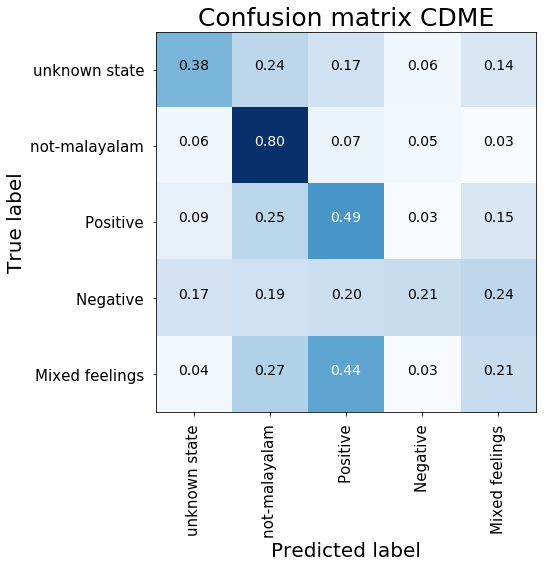

In [69]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix CDME")
plt.show()

In [24]:
concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
dme = DME(max_len)
x = dme(concat_inp.output)
x = Conv1D(64, 5, activation='relu')(x)#GRU(128, dropout=0.2, return_sequences=True)(x)
x=MaxPooling1D(pool_size=2)(x)
x = LSTM(32, dropout=0.2)(x)
out = Dense(y_train.shape[1], activation='softmax',kernel_regularizer=regularizers.l1(0.01))(x)

dme_model = Model(concat_inp.input, out)
dme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dme_model.summary()

W0113 16:11:21.759098 140640957007616 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0113 16:11:21.883585 140640957007616 deprecation.py:506] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0113 16:11:22.209970 140640957007616 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 100)     1371200     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 100)     1371200     input_4[0][0]                    
__________________________________________________________________________________________________
reshape_3 

In [29]:
dme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=10, verbose=2, validation_split=0.1,class_weight=class_weights)

Train on 4851 samples, validate on 540 samples
Epoch 1/10
 - 22s - loss: 1.1909 - acc: 0.5700 - val_loss: 1.1932 - val_acc: 0.5574
Epoch 2/10
 - 22s - loss: 1.1805 - acc: 0.5764 - val_loss: 1.2466 - val_acc: 0.5148
Epoch 3/10
 - 22s - loss: 1.1808 - acc: 0.5782 - val_loss: 1.1878 - val_acc: 0.5593
Epoch 4/10
 - 22s - loss: 1.1723 - acc: 0.5805 - val_loss: 1.1952 - val_acc: 0.5463
Epoch 5/10
 - 22s - loss: 1.1682 - acc: 0.5900 - val_loss: 1.2009 - val_acc: 0.5556
Epoch 6/10
 - 22s - loss: 1.1572 - acc: 0.5927 - val_loss: 1.2018 - val_acc: 0.5370
Epoch 7/10
 - 23s - loss: 1.1568 - acc: 0.5908 - val_loss: 1.1788 - val_acc: 0.5722
Epoch 8/10
 - 24s - loss: 1.1525 - acc: 0.5906 - val_loss: 1.1864 - val_acc: 0.5463
Epoch 9/10
 - 24s - loss: 1.1419 - acc: 0.6003 - val_loss: 1.1870 - val_acc: 0.5500
Epoch 10/10
 - 24s - loss: 1.1358 - acc: 0.6013 - val_loss: 1.1735 - val_acc: 0.5648


/home/bharaj/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

Mixed feelings        0.52      0.56      0.54       398
      Negative        0.43      0.56      0.49       177
      Positive        0.58      0.70      0.63       565
 not-malayalam        0.40      0.01      0.03       138
 unknown state        0.00      0.00      0.00        70

      micro avg       0.53      0.53      0.53      1348
      macro avg       0.38      0.37      0.34      1348
   weighted avg       0.49      0.53      0.49      1348



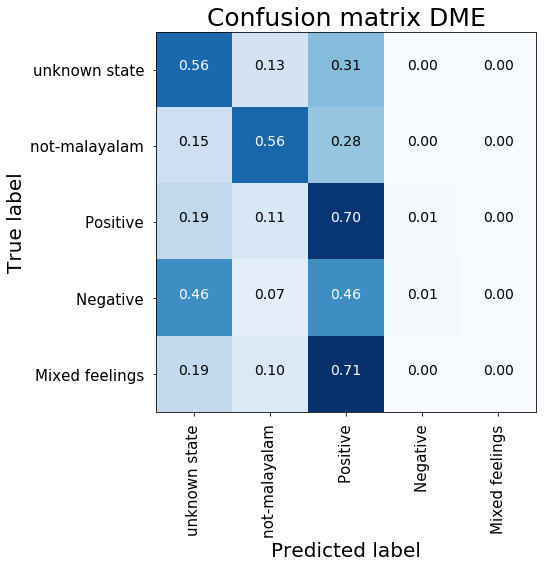

In [30]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)]))
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix DME")
plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 200, 100)     1371200     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 200, 100)     1371200     input_10[0][0]                   
__________________________________________________________________________________________________
reshape_11

/home/bharaj/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

Mixed feelings        0.52      0.56      0.54       398
      Negative        0.43      0.56      0.49       177
      Positive        0.58      0.70      0.63       565
 not-malayalam        0.40      0.01      0.03       138
 unknown state        0.00      0.00      0.00        70

      micro avg       0.53      0.53      0.53      1348
      macro avg       0.38      0.37      0.34      1348
   weighted avg       0.49      0.53      0.49      1348



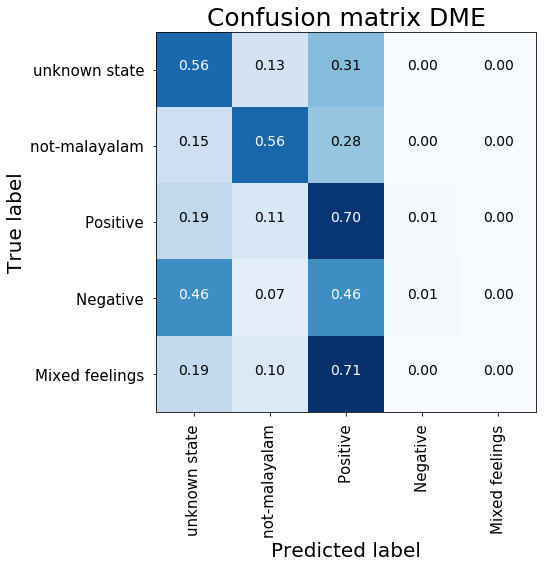

In [31]:
### DEFINE NETWORK WITH CDME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
cdme = CDME(max_len)
x = cdme(concat_inp.output)
x = Conv1D(64, 5, activation='relu')(x)#GRU(128, dropout=0.2, return_sequences=True)(x)
x=MaxPooling1D(pool_size=2)(x)
x = LSTM(32, dropout=0.2)(x)
out = Dense(y_train.shape[1], activation='softmax',kernel_regularizer=regularizers.l1(0.01))(x)

cdme_model = Model(concat_inp.input, out)
cdme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cdme_model.summary()
cdme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=10, verbose=2, validation_split=0.1,class_weight=class_weights)
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)]))
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix DME")
plt.show()